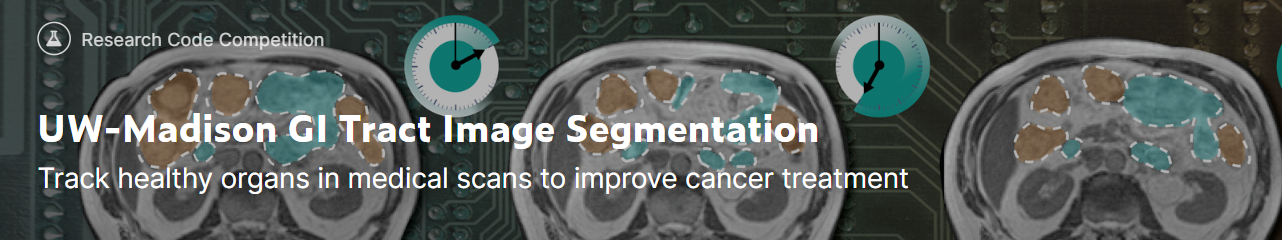

## Data description:
In this competition we are segmenting organs cells in images. The training annotations are provided as RLE-encoded masks, and the images are in 16-bit grayscale PNG format.

Each case in this competition is represented by multiple sets of scan slices (each set is identified by the day the scan took place). Some cases are split by time (early days are in train, later days are in test) while some cases are split by case - the entirety of the case is in train or test. The goal of this competition is to be able to generalize to both partially and wholly unseen cases.

Note that, in this case, the test set is entirely unseen. It is roughly 50 cases, with a varying number of days and slices, as seen in the training set.

How does an entirely hidden test set work?
The test set in this competition is only available when your code is submitted. The sample_submission.csv provided in the public set is an empty placeholder that shows the required submission format; you should perform your modeling, cross-validation, etc., using the training set, and write code to process a non-empty sample submission. It will contain rows with id, class and predicted columns as described in the Evaluation page.

When you submit your notebook, your code will be run against the non-hidden test set, which has the same folder format (<case>/<case_day>/<scans>) as the training data.

### Files
>- train.csv - IDs and masks for all training objects.
>- sample_submission.csv - a sample submission file in the correct format
>- train - a folder of case/day folders, each containing slice images for a particular case on a given day.

    Note that the image filenames include 4 numbers (ex. 276_276_1.63_1.63.png). These four numbers are slice height / width (integers in pixels) and heigh/width pixel spacing (floating points in mm). The first two defines the resolution of the slide. The last two record the physical size of each pixel. Physical pixel thickness in superior-inferior direction is 3mm.

### Columns
>- id - unique identifier for object
>- class - the predicted class for the object
>- EncodedPixels - RLE-encoded pixels for the identified object
    
## Evaluation metric: 
    This competition is evaluated on the mean Dice coefficient and 3D Hausdorff distance (weight of 0.4 for the Dice metric and 0.6 for the Hausdorff distance)

## Import packages

In [ ]:
# Install required packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import animation, rc
import imageio
import time
import cv2
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import tensorflow as tf
from skimage.morphology import label
import random
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import StratifiedKFold
from skimage.segmentation import watershed
from skimage.measure import label
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import torch
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A
import random
import pickle
import os
import collections
from sklearn.model_selection import train_test_split
import torchvision
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
SEED = 42

In [ ]:
# Fix randomness

def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
    
fix_all_seeds(SEED)

## Load data

In [ ]:
train_data = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/train.csv')
sample_submission_data = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/sample_submission.csv')

## EDA

In [ ]:
print(sample_submission_data.shape)
sample_submission_data.head()

In [ ]:
print(train_data.shape, train_data.id.nunique())
train_data[train_data['segmentation'].notna()].head()

In [ ]:
train_data['case'] = train_data['id'].apply(lambda x: x.split('_')[0])
train_data['day'] = train_data['id'].apply(lambda x: x.split('_')[1])
train_data['slice'] = train_data['id'].apply(lambda x: x.split('_')[2] + '_' + x.split('_')[3])

In [ ]:
train_data[(train_data['case']=='case123') & (train_data['segmentation'].notna())]

In [ ]:
print('\nUnique classes:', train_data['class'].unique())
print('# Images per class:\n')
print('# Images with segmentation:', train_data[train_data['segmentation'].notna()]['id'].nunique(), '(' + str(train_data[train_data['segmentation'].notna()]['id'].nunique()/train_data['id'].nunique() * 100) + ' % out of',str(train_data['id'].nunique()) + ')')
train_data.groupby(['class']).agg({'id':'nunique','segmentation':'count'}).reset_index().rename(columns = {'id':'# Images','segmentation':'# Images with annotation'})

In [ ]:
# Helper functions
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height, width, channels) of array to return 
    color: color for the mask
    Returns numpy array (mask)

    '''
    s = mask_rle.split()
    
    starts = list(map(lambda x: int(x) - 1, s[0::2]))
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]
    
    if len(shape)==3:
        img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    else:
        img = np.zeros(shape[0] * shape[1], dtype=np.float32)
        
    for start, end in zip(starts, ends):
        img[start : end] = color
    
    return img.reshape(shape)

In [ ]:
# Visualize any image
def plot_images_and_masks(sample_id):
    case_num = sample_id.split('_')[0]
    day_num = sample_id.split('_')[1]
    slice_num = [x for x in os.listdir(f'../input/uw-madison-gi-tract-image-segmentation/train/{case_num}/{case_num + "_" + day_num}/scans/') if sample_id.split('_')[3] in x.split('_')[1]][0]
    path = f'../input/uw-madison-gi-tract-image-segmentation/train/{case_num}/{case_num + "_" + day_num}/scans/{slice_num}'
    image_data = plt.imread(path)
    print('\nID:', sample_id,'\n')
    print('\nTrain data records:')
    display(train_data[(train_data['id']==sample_id) & (train_data['segmentation'].notna())].reset_index(drop = True))
    print('\nImage data shape:', image_data.shape)
    print('Min and max pixels:', image_data.min(),',', image_data.max(),'\n')
    plt.subplot(1, 2, 1)
    plt.imshow(image_data, cmap = 'gray')
    plt.title('Input image')
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(image_data, cmap = 'gray')
    for i in range(0, train_data[(train_data['id']==sample_id) & (train_data['segmentation'].notna())].shape[0]):
        plt.imshow(rle_decode(train_data[(train_data['id']==sample_id) & (train_data['segmentation'].notna())]['segmentation'].tolist()[i], shape = image_data.shape), alpha = 0.4, cmap ='gray')
    plt.title('Input image with mask')
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
sample_id = 'case123_day0_slice_0111'
plot_images_and_masks(sample_id)

In [ ]:
train_data[(train_data['case']=='case123') & (train_data['day']=='day0') & (train_data['segmentation'].notna())].tail()['id'].tolist()

In [ ]:
# Provide a list of IDs
list_ids = train_data[(train_data['case']=='case123') & (train_data['day']=='day0') & (train_data['segmentation'].notna())].tail()['id'].tolist()
for sample_id in list_ids:
    plot_images_and_masks(sample_id)

In [ ]:
rc('animation', html='jshtml')

def create_animation(ims):
    print('# Images:', len(ims))
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    im = plt.imshow(ims[0], cmap="gray")

    def animate_func(i):
        im.set_array(ims[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames = len(ims), interval = 1)

In [ ]:
# See images for a case number and day number
case_num = 'case123'
day_num = 'day0'
list_images_data = []
for images in os.listdir(f'../input/uw-madison-gi-tract-image-segmentation/train/{case_num}/{case_num}_{day_num}/scans/'):
    image_data = plt.imread(f'../input/uw-madison-gi-tract-image-segmentation/train/{case_num}/{case_num}_{day_num}/scans/' + images)
    list_images_data.append(image_data)
create_animation(list_images_data)

## Modelling

We need to build a model to identify where healthy organs (stomach, large and small bowels) are present in an MRI scan. We would be building a mask R-CNN model to do this.

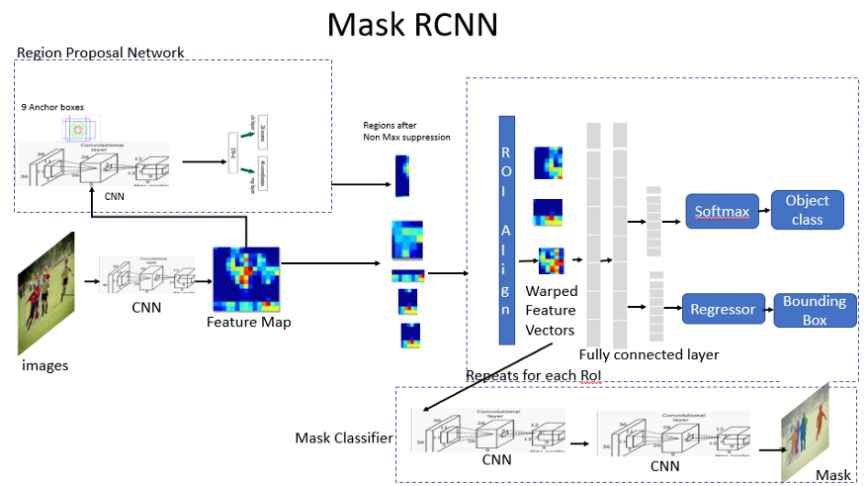

### Config

In [ ]:
PATH = '../input/uw-madison-gi-tract-image-segmentation'
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BATCH_SIZE = 2
NUM_EPOCHS = 7

WIDTH = 512
HEIGHT = 512

resize_factor = True
flip_prob = 0.2

# Normalize to resnet mean and std if True.
NORMALIZE = False

# RESNET_MEAN = (0.485, 0.456, 0.406)
# RESNET_STD = (0.229, 0.224, 0.225)

MOMENTUM = 0.9
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005

# Changes the confidence required for a pixel to be kept for a mask. 
cell_type_dict = {"stomach": 1, "large_bowel": 2, "small_bowel": 3}
idx_to_cell_type = {v: k for k, v in cell_type_dict.items()}
mask_threshold_dict = {1: 0.5, 2: 0.5, 3:  0.5}
min_score_dict = {1: 0.5, 2: 0.5, 3: 0.5}

# Use a StepLR scheduler if True. 
USE_SCHEDULER = False

train_valid_ratio = 0.1

BOX_DETECTIONS_PER_IMG = 100

### Data preparation

In [ ]:
# Helper functions
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))


def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask

def combine_masks(masks, mask_threshold):
    """
    combine masks into one image
    """
    masking = np.zeros((HEIGHT, WIDTH))
    # print(len(masks.shape), masks.shape)
    for m, mask in enumerate(masks,1):
        masking[mask>mask_threshold] = m
    return masking


def get_filtered_masks(pred):
    """
    filter masks using MIN_SCORE for mask and MAX_THRESHOLD for pixels
    """
    use_masks = []   
    for i, mask in enumerate(pred["masks"]):

        # Filter-out low-scoring results. Not tried yet.
        scr = pred["scores"][i].cpu().item()
        label = pred["labels"][i].cpu().item()
        if scr > min_score_dict[label]:
            mask = mask.cpu().numpy().squeeze()
            # Keep only highly likely pixels
            binary_mask = mask > mask_threshold_dict[label]
            binary_mask = remove_overlapping_pixels(binary_mask, use_masks)
            use_masks.append(binary_mask)

    return use_masks

In [ ]:
#Metric: mean of the precision values at each IoU threshold
#Ref: https://www.kaggle.com/theoviel/competition-metric-map-iou

def compute_iou(labels, y_pred, verbose=0):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    if verbose:
        print("Number of true objects: {}".format(true_objects))
        print("Number of predicted objects: {}".format(pred_objects))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    intersection = intersection[1:, 1:] # exclude background
    union = union[1:, 1:]
    union[union == 0] = 1e-9
    iou = intersection / union
    
    return iou  

def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

def iou_map(truths, preds, verbose=0):
    """
    Computes IOU.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    ious = [compute_iou(truth, pred, verbose) for truth, pred in zip(truths, preds)]

    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)


def get_score(ds, mdl, threshold_dict):
    """
    Get average IOU mAP score for a dataset
    """
    mdl.eval()
    iouscore = 0
    for i in tqdm(range(len(ds))):
        img, targets = ds[i]
        with torch.no_grad():
            result = mdl([img.to(DEVICE)])[0]
            
        masks = combine_masks(targets['masks'], 0.5)
        labels = pd.Series(result['labels'].cpu().numpy()).value_counts()

        mask_threshold = threshold_dict[labels.sort_values().index[-1]]
        pred_masks = combine_masks(get_filtered_masks(result), mask_threshold)
        iouscore += iou_map([masks],[pred_masks])
    return iouscore / len(ds)

In [ ]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class VerticalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-2)
            bbox = target["boxes"]
            bbox[:, [1, 3]] = height - bbox[:, [3, 1]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-2)
        return image, target

class HorizontalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-1)
        return image, target

class Normalize:
    def __call__(self, image, target):
        image = F.normalize(image, RESNET_MEAN, RESNET_STD)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target
    

def get_transform(train):
    transforms = [ToTensor()]
    if NORMALIZE:
        transforms.append(Normalize())
    
    # Data augmentation for train
    if train: 
        transforms.append(HorizontalFlip(flip_prob))
        transforms.append(VerticalFlip(flip_prob))

    return Compose(transforms)

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, df, train_flag, transforms=None, resize=False):
        self.transforms = transforms
        self.image_dir = image_dir
        self.df = df
        self.train_flag = 'train'
        
        self.should_resize = resize is not False
        if self.should_resize:
            self.height = int(HEIGHT * resize)
            self.width = int(WIDTH * resize)
            print("image size used:", self.height, self.width)
        else:
            self.height = HEIGHT
            self.width = WIDTH
        
        self.image_info = collections.defaultdict(dict)
        
        temp_df = self.df.groupby(["id"])['segmentation'].agg(lambda x: list(x)).reset_index().merge(self.df.groupby(["id"])['class'].agg(lambda x: list(x)).reset_index(), how = 'left', on = 'id')
        
        for index, row in temp_df.iterrows():
            sample_id = row['id']
            case_num = sample_id.split('_')[0]
            day_num = sample_id.split('_')[1]
            slice_num = [x for x in os.listdir(f'../input/uw-madison-gi-tract-image-segmentation/{self.train_flag}/{case_num}/{case_num + "_" + day_num}/scans/') if sample_id.split('_')[3] in x.split('_')[1]][0]
            path = f'{self.image_dir}/{self.train_flag}/{case_num}/{case_num + "_" + day_num}/scans/{slice_num}'
            self.image_info[index] = {
                    'image_id': row['id'],
                    'image_path': path,
                    'annotations': row["segmentation"],
                    'class': [cell_type_dict[x] for x in row["class"]]
                    }
            
    def get_box(self, a_mask):
        ''' Get the bounding box of a given mask '''
        pos = np.where(a_mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        return [xmin, ymin, xmax, ymax]

    def __getitem__(self, idx):
        ''' Get the image and the target'''
        
        img_path = self.image_info[idx]["image_path"]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        initial_HEIGHT = img.shape[0]
        initial_WIDTH = img.shape[1]
        
        if self.should_resize:
            img = cv2.resize(img, (self.width, self.height))

        info = self.image_info[idx]

        n_objects = len(info['annotations'])
        masks = np.zeros((len(info['annotations']), self.height, self.width), dtype=np.uint8)
        boxes = []
        labels = []
        for i, annotation in enumerate(info['annotations']):
            a_mask = rle_decode(annotation, (initial_HEIGHT, initial_WIDTH))
            
            if self.should_resize:
                a_mask = cv2.resize(a_mask, (self.width, self.height))
            
            a_mask = np.array(a_mask) > 0
            masks[i, :, :] = a_mask
            
            boxes.append(self.get_box(a_mask))

        # labels
        labels = [int(info["class"][m]) for m in range(0, (n_objects))]        
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((n_objects,), dtype=torch.int64)

        # This is the required target for the Mask R-CNN
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
#             'image_path':img_path
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.image_info)

In [ ]:
temp = train_data.groupby(['id','class']).agg({'segmentation':'count'}).reset_index().pivot_table(index = 'id', columns = 'class', values = 'segmentation').reset_index()
temp['all 3 organs'] = temp[['large_bowel','small_bowel','stomach']].sum(axis = 1)
temp[temp['large_bowel']>0].head()

In [ ]:
df_images_train, df_images_val = train_test_split(temp, stratify=temp['all 3 organs'], 
                                                  test_size=train_valid_ratio,
                                                  random_state=SEED)

In [ ]:
print('# Images in train and valid:', df_images_train.shape[0],'and', df_images_val.shape[0])
df_train = train_data[(train_data['id'].isin(df_images_train['id'])) & (train_data['segmentation'].notna())]
df_val = train_data[(train_data['id'].isin(df_images_val['id'])) & (train_data['segmentation'].notna())]

In [ ]:
ds_train = ImageDataset(PATH, df_train, train_flag = 'train', resize=resize_factor, transforms=get_transform(train=True))
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,
                      num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

ds_val = ImageDataset(PATH, df_val, train_flag = 'train', resize=resize_factor, transforms=get_transform(train=False))
dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,
                    num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
# Override pythorch checkpoint with an "offline" version of the file
!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp ../input/cocopre/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth

In [ ]:
def get_model(num_classes, model_chkpt=None):
    # This is just a dummy value for the classification head
    
    if NORMALIZE:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
                                                                   box_detections_per_img=BOX_DETECTIONS_PER_IMG,
                                                                   image_mean=RESNET_MEAN,
                                                                   image_std=RESNET_STD)
    else:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
                                                                   box_detections_per_img=BOX_DETECTIONS_PER_IMG)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes+1)
    
    if model_chkpt:
        model.load_state_dict(torch.load(model_chkpt, map_location=DEVICE))
    return model

# Get the Mask R-CNN model
# The model does classification, bounding boxes and MASKs for individuals, all at the same time
# We only care about MASKS


# Load trained model to train further
e = 7
model_chk = f"../input/mask-rcnn-trained/pytorch_model-e{e}.bin"
print("Loading:", model_chk)
model = get_model(len(cell_type_dict), model_chk)
model.load_state_dict(torch.load(model_chk))
model = model.to(DEVICE)

for param in model.parameters():
    param.requires_grad = True
    
model.train()

In [ ]:
# Checking if the data preparation pipeline for model is correct
print('\nFrom data loader\n')
dummy = ds_train[300]
plt.imshow(dummy[0][0],cmap = 'gray')
plt.show()
plt.imshow(dummy[0][0],cmap = 'gray')
plt.imshow(dummy[1]['masks'][0],cmap = 'gray', alpha = 0.4)
if len(dummy[1]['masks'])==2:
    plt.imshow(dummy[1]['masks'][1],cmap = 'gray', alpha = 0.4)
plt.show()

print('\nFrom train data\n')
sample_id = 'case107_day0_slice_0111'
plot_images_and_masks(sample_id)

### Model training

In [ ]:
TRAIN = True

In [ ]:
if TRAIN:
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    #optimizer = torch.optim.Adam(params, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    n_batches, n_batches_val = len(dl_train), len(dl_val)

    validation_mask_losses = []

    for epoch in range(1, NUM_EPOCHS + 1):
        print(f"Starting epoch {epoch} of {NUM_EPOCHS}")

        time_start = time.time()
        loss_accum = 0.0
        loss_mask_accum = 0.0
        loss_classifier_accum = 0.0
        for batch_idx, (images, targets) in enumerate(dl_train, 1):
            # Predict
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Logging
            loss_mask = loss_dict['loss_mask'].item()
            loss_accum += loss.item()
            loss_mask_accum += loss_mask
            loss_classifier_accum += loss_dict['loss_classifier'].item()

            if batch_idx % 500 == 0:
                print(f"    [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}. Mask-only loss: {loss_mask:7.3f}. {time.time() - time_start:.0f} secs")

        if USE_SCHEDULER:
            lr_scheduler.step()

        # Train losses
        train_loss = loss_accum / n_batches
        train_loss_mask = loss_mask_accum / n_batches
        train_loss_classifier = loss_classifier_accum / n_batches

        # Validation
        val_loss_accum = 0
        val_loss_mask_accum = 0
        val_loss_classifier_accum = 0

        with torch.no_grad():
            for batch_idx, (images, targets) in enumerate(dl_val, 1):
                images = list(image.to(DEVICE) for image in images)
                targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

                val_loss_dict = model(images, targets)
                val_batch_loss = sum(loss for loss in val_loss_dict.values())
                val_loss_accum += val_batch_loss.item()
                val_loss_mask_accum += val_loss_dict['loss_mask'].item()
                val_loss_classifier_accum += val_loss_dict['loss_classifier'].item()

        # Validation losses
        val_loss = val_loss_accum / n_batches_val
        val_loss_mask = val_loss_mask_accum / n_batches_val
        val_loss_classifier = val_loss_classifier_accum / n_batches_val
        elapsed = time.time() - time_start

        validation_mask_losses.append(val_loss_mask)

        torch.save(model.state_dict(), f"pytorch_model-e{epoch}.bin")
        prefix = f"[Epoch {epoch:2d} / {NUM_EPOCHS:2d}]"
        print(prefix)
        print(f"{prefix} Train mask-only loss: {train_loss_mask:7.3f}, classifier loss {train_loss_classifier:7.3f}")
        print(f"{prefix} Val mask-only loss  : {val_loss_mask:7.3f}, classifier loss {val_loss_classifier:7.3f}")
        print(prefix)
        print(f"{prefix} Train loss: {train_loss:7.3f}. Val loss: {val_loss:7.3f} [{elapsed:.0f} secs]")
        print(prefix)

### Model validation

In [ ]:
# Load trained model
e = 7
# model_chk = f"../input/mask-rcnn-trained/pytorch_model-e{5}.bin"
model_chk = f"pytorch_model-e{e}.bin"
print("Loading:", model_chk)
model = get_model(len(cell_type_dict), model_chk)
model.load_state_dict(torch.load(model_chk))
model = model.to(DEVICE)

In [ ]:
def analyze_train_sample(model, ds_train, sample_index):
    img, targets = ds_train[sample_index]
    #print(img.shape)
    l = np.unique(targets["labels"])
    ig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,60), facecolor="#fefefe")
    ax[0].imshow(img[0,:,:], cmap = 'gray')
    ax[0].set_title(f"cell type {l}")
    ax[0].axis("off")
    
    masks = combine_masks(targets['masks'], 0.5)
    #plt.imshow(img.numpy().transpose((1,2,0)))
    ax[1].imshow(masks)
    ax[1].set_title(f"Ground truth, {len(targets['masks'])} cells")
    ax[1].axis("off")
    
    model.eval()
    with torch.no_grad():
        preds = model([img.to(DEVICE)])[0]
    
    l = pd.Series(preds['labels'].cpu().numpy()).value_counts()
#     lstr = ""
#     for i in l.index:
#         lstr += f"{l[i]} {idx_to_cell_type[i]}. "
    #print(l, l.sort_values().index[-1])
    #plt.imshow(img.cpu().numpy().transpose((1,2,0)))
    mask_threshold = mask_threshold_dict[l.sort_values().index[-1]]
    #print(mask_threshold)
    pred_masks = combine_masks(get_filtered_masks(preds), mask_threshold)
    ax[2].imshow(pred_masks)
    ax[2].set_title(f"Predictions")
#     ax[2].set_title(f"Predictions, labels: {lstr}")
    ax[2].axis("off")
    plt.show() 
    
    #print(masks.shape, pred_masks.shape)
    score = iou_map([masks],[pred_masks])
    print("IOU score:", score)    
    
    
# NOTE: It puts the model in eval mode!! Revert for re-training
analyze_train_sample(model, ds_train, 300)

In [ ]:
# Find best threshold based on validation dataset for each organ
valid_data_threhsold_analysis = pd.DataFrame(data = None, columns = ['stomach', 'large_bowel', 'small_bowel', 'IoU'])
i = 0
for stomach_prob in range(45, 55, 5):
    for large_bowel_prob in range(45, 55, 5):
        for small_bowel_prob in range(45, 55, 5):
            mask_threshold_dict = {1:stomach_prob/100, 2: large_bowel_prob/100, 3: small_bowel_prob/100}
            valid_data_threhsold_analysis.loc[i] = stomach_prob/100, large_bowel_prob/100, small_bowel_prob/100, get_score(ds_val, model, mask_threshold_dict)
            i +=1
valid_data_threhsold_analysis

## Inference

In [ ]:
class Test_ImageDataset(Dataset):
    def __init__(self, image_dir, df, train_flag, transforms=None, resize=False):
        self.transforms = transforms
        self.image_dir = image_dir
        self.df = df
        self.train_flag = train_flag
        
        self.should_resize = resize is not False
        if self.should_resize:
            self.height = int(HEIGHT * resize)
            self.width = int(WIDTH * resize)
            print("image size used:", self.height, self.width)
        else:
            self.height = HEIGHT
            self.width = WIDTH
        
        self.image_info = collections.defaultdict(dict)
        
        temp_df = self.df.copy()
        
        for index, row in temp_df.iterrows():
            sample_id = row['id']
            case_num = sample_id.split('_')[0]
            day_num = sample_id.split('_')[1]
            slice_num = [x for x in os.listdir(f'../input/uw-madison-gi-tract-image-segmentation/{self.train_flag}/{case_num}/{case_num + "_" + day_num}/scans/') if sample_id.split('_')[3] in x.split('_')[1]][0]
            path = f'{self.image_dir}/{self.train_flag}/{case_num}/{case_num + "_" + day_num}/scans/{slice_num}'
            self.image_info[index] = {
                    'image_id': row['id'],
                    'image_path': path,
#                     'annotations': row["segmentation"],
#                     'class': [cell_type_dict[x] for x in row["class"]]
                    }

    def __getitem__(self, idx):
        ''' Get the image and the target'''
        
        img_path = self.image_info[idx]["image_path"]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        initial_HEIGHT = img.shape[0]
        initial_WIDTH = img.shape[1]
        
        if self.should_resize:
            img = cv2.resize(img, (self.width, self.height))

        info = self.image_info[idx]
        image_id = self.image_info[idx]["image_id"]

        # This is the required target for the Mask R-CNN
        target = {
#             'boxes': boxes,
#             'labels': labels,
#             'masks': masks,
            'image_id': image_id,
            'initial_HEIGHT': initial_HEIGHT,
            'initial_WIDTH': initial_WIDTH
#             'area': area,
#             'iscrowd': iscrowd
#             'image_path':img_path
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.image_info)

In [ ]:
df_test = train_data[train_data['segmentation'].notna()][['id']].iloc[0:100].drop_duplicates().reset_index(drop = True)
# df_test = sample_submission_data.drop(columns = ['class','predicted']).drop_duplicates().reset_index(drop = True)
ds_test = Test_ImageDataset(PATH, df_test, train_flag = 'train', resize=resize_factor, transforms=get_transform(train=False))
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True,
                      num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
for param in model.parameters():
    param.requires_grad = False

model.eval();

submission = []
for num in range(0, len(ds_test)):
    sample = ds_test[num]
    img = sample[0]
    image_id = sample[1]['image_id']
    initial_HEIGHT = sample[1]['initial_HEIGHT']
    initial_WIDTH = sample[1]['initial_WIDTH']
    with torch.no_grad():
        result = model([img.to(DEVICE)])[0]
    
    for cell_type in range(1, len(min_score_dict)+1):
        previous_masks = []
        for i, mask in enumerate(result["masks"]):
            # Filter-out low-scoring results.
            score = result["scores"][i].cpu().item()
            label = result["labels"][i].cpu().item()
            if (score > min_score_dict[label]) & (label==cell_type):
                mask = mask.cpu().numpy()
                # Keep only highly likely pixels
                mask = cv2.resize(mask.reshape((HEIGHT,WIDTH,1)), (initial_WIDTH, initial_HEIGHT))[None,:,:]
                binary_mask = mask > mask_threshold_dict[label]
                binary_mask = remove_overlapping_pixels(binary_mask, previous_masks)
                previous_masks.append(binary_mask)
                
        previous_masks = torch.tensor([item for sublist in previous_masks for item in sublist])
        binary_mask = np.zeros((initial_HEIGHT, initial_WIDTH))
        for m, mask in enumerate(previous_masks,1):
            binary_mask[mask>0.5] = 1
        rle = rle_encoding(binary_mask)
        submission.append((image_id, {v:k for k,v in cell_type_dict.items()}[cell_type], rle))

    # Add empty prediction if no RLE was generated for this image
    all_images_ids = [image_id for image_id, label, rle in submission]
    if image_id not in all_images_ids:
        submission.append((image_id, list(cell_type_dict.keys())[0], ""))
        submission.append((image_id, list(cell_type_dict.keys())[1], ""))
        submission.append((image_id, list(cell_type_dict.keys())[2], ""))

In [ ]:
df_sub = pd.DataFrame(submission, columns=['id', 'class', 'predicted'])
df_sub.to_csv("submission.csv", index=False)
print('Test data shape:', df_sub.shape)
display(df_sub.head())

In [ ]:
sample_id = 'case123_day20_slice_0065'
case_num = sample_id.split('_')[0]
day_num = sample_id.split('_')[1]
slice_num = [x for x in os.listdir(f'../input/uw-madison-gi-tract-image-segmentation/train/{case_num}/{case_num + "_" + day_num}/scans/') if sample_id.split('_')[3] in x.split('_')[1]][0]
path = f'../input/uw-madison-gi-tract-image-segmentation/train/{case_num}/{case_num + "_" + day_num}/scans/{slice_num}'
image_data = plt.imread(path)
print('\nID:', sample_id,'\n')
print('\nTrain data records:')
display(train_data[(train_data['id']==sample_id) & (train_data['segmentation'].notna())].reset_index(drop = True))
print('\nImage data shape:', image_data.shape)
print('Min and max pixels:', image_data.min(),',', image_data.max(),'\n')
plt.subplot(1, 3, 1)
plt.imshow(image_data, cmap = 'gray')
plt.title('Input image')
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(image_data, cmap = 'gray')
for i in range(0, train_data[(train_data['id']==sample_id) & (train_data['segmentation'].notna())].shape[0]):
    plt.imshow(rle_decode(train_data[(train_data['id']==sample_id) & (train_data['segmentation'].notna())]['segmentation'].tolist()[i], shape = image_data.shape), alpha = 0.4, cmap ='gray')
plt.title('Ground truth mask')
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(image_data, cmap = 'gray')
for i in range(0, df_sub[(df_sub['id']==sample_id) & (df_sub['predicted']!='')].shape[0]):
    plt.imshow(rle_decode(df_sub[(df_sub['id']==sample_id) & (df_sub['predicted'].notna())]['predicted'].tolist()[i], shape = image_data.shape), alpha = 0.4, cmap ='gray')
plt.title('Predicted mask')
plt.axis("off")
plt.show()

In [ ]:
print('# Classes for test images:', df_sub['id'].value_counts().reset_index().rename(columns = {'id':'# Cells'})['# Cells'].unique()[0])